In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import copy 
from sklearn.linear_model import LinearRegression
import tensorflow as tf

In [41]:
df = pd.read_csv('SeoulBikeData.csv')
df = df[df['Hour']==12]
df = df.drop(['Date','Holiday','Seasons','Hour'],axis=1)
df['FunctioningDay'] = (df['FunctioningDay']=='Yes').astype(int)
cols = list(df.columns)
print(cols)
df.head()

['Rented_Bike_Count', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point temperature', 'SolarRadiation', 'Rainfall', 'Snowfall', 'FunctioningDay']


,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Dew_point temperature,SolarRadiation,Rainfall,Snowfall,FunctioningDay
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


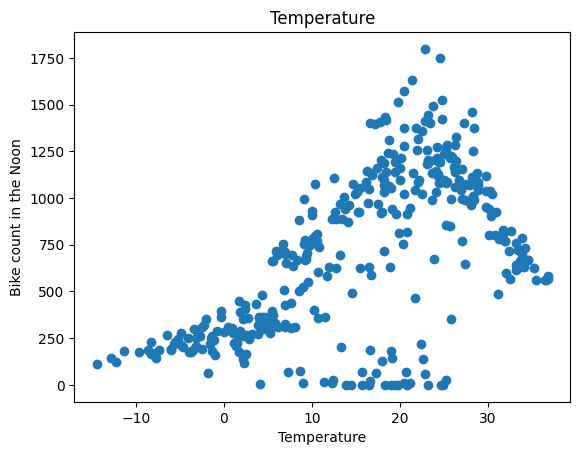

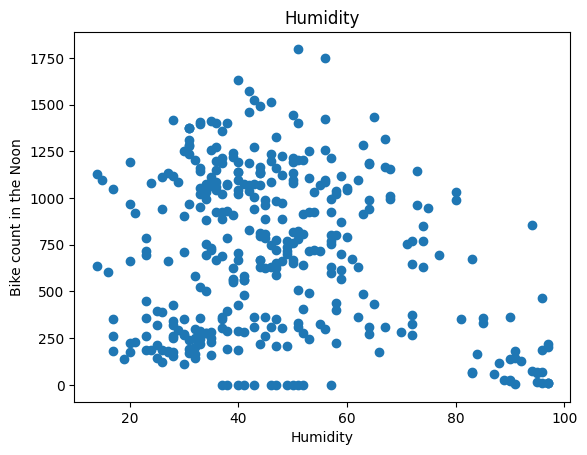

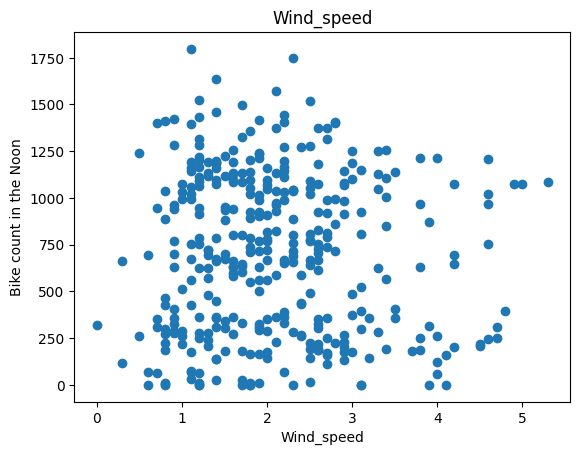

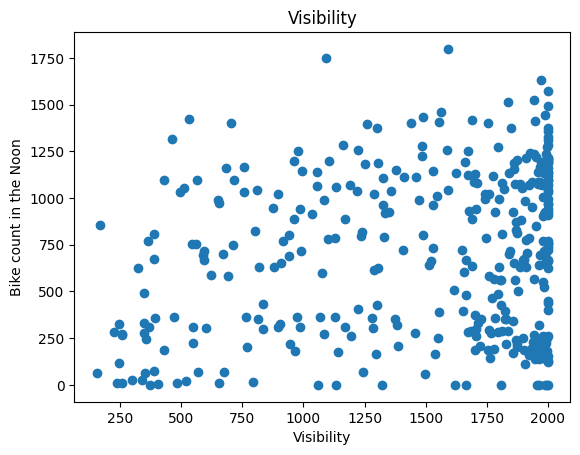

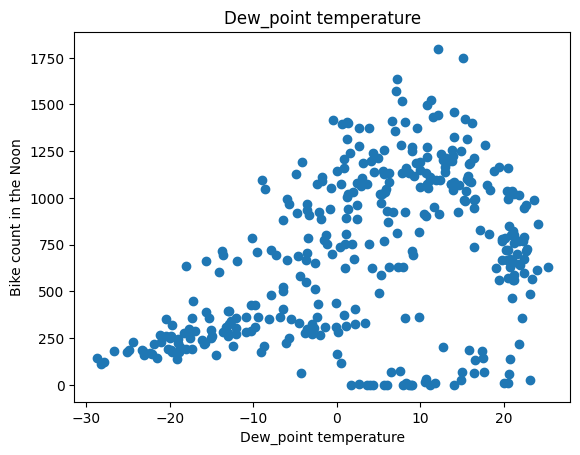

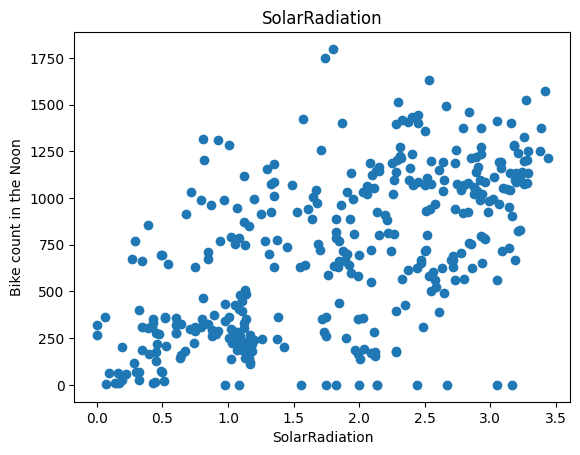

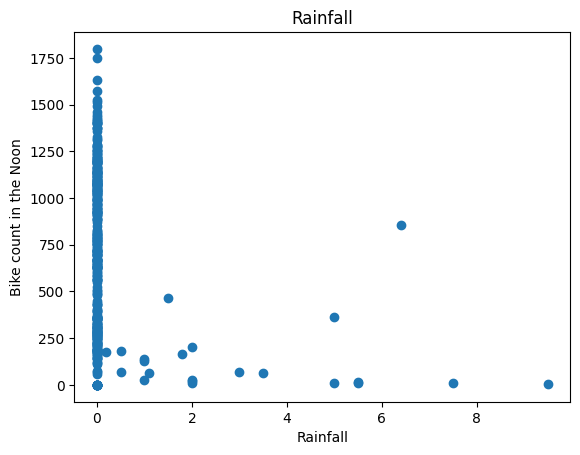

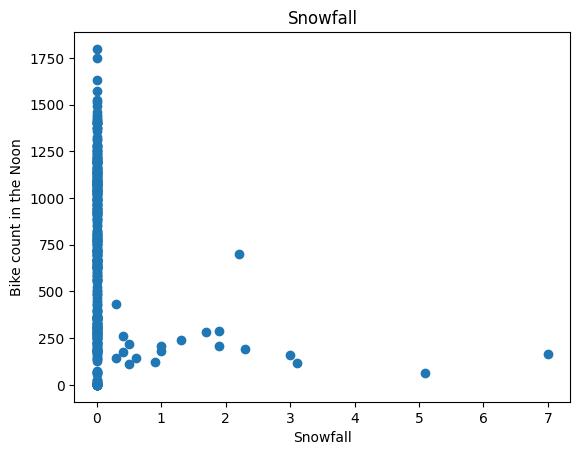

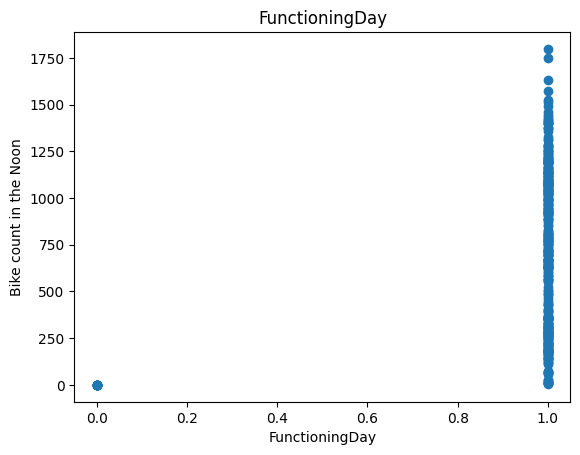

In [42]:
for label in cols[1:]:
    plt.scatter(df[label],df['Rented_Bike_Count'])
    plt.title(label)
    plt.ylabel('Bike count in the Noon')
    plt.xlabel(label)
    plt.show()

# Dropping the feature that are not linear to the "Rented_Bike_Count"	

In [43]:
df = df.drop(['Wind_speed','Visibility','FunctioningDay'],axis=1)
df.head()

,Rented_Bike_Count,Temperature,Humidity,Dew_point temperature,SolarRadiation,Rainfall,Snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [44]:
train, valid , test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

C:\Users\dhurk\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [45]:
def getXy(dataframe, ylabel, xlabel=None):
    dataframe = dataframe.copy()
    if xlabel is None:
        X = dataframe.drop(columns=[ylabel]).values  # Drop target column to get features
    else:
        missing_cols = [col for col in xlabel if col not in dataframe.columns]
        if missing_cols:
            raise KeyError(f"Missing columns: {missing_cols}")

        X = dataframe[xlabel].values if len(xlabel) > 1 else dataframe[xlabel[0]].values.reshape(-1, 1)

    y = dataframe[ylabel].values.reshape(-1, 1)
    data = np.hstack((X, y))
    return data, X, y

In [46]:
train, train_X, train_y = getXy(train,"Rented_Bike_Count",xlabel=['Temperature'])
valid, valid_X, valid_y = getXy(valid,"Rented_Bike_Count",xlabel=['Temperature'])
test, test_X, test_y = getXy(test,"Rented_Bike_Count",xlabel=['Temperature'])

In [47]:
regModel = LinearRegression()
regModel.fit(train_X,train_y)

LinearRegression()

In [48]:
regModel.score(test_X,test_y)

0.22024326045324782

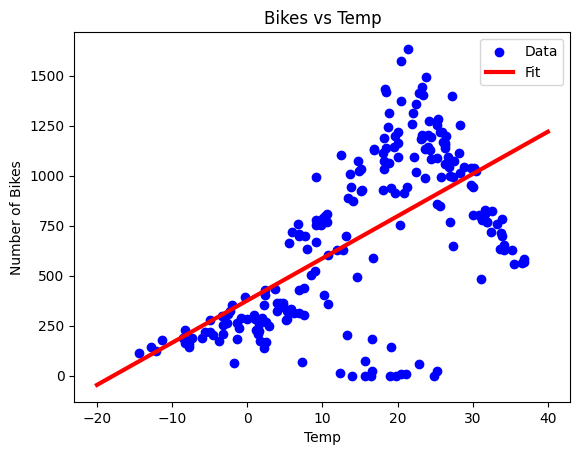

In [49]:
plt.scatter(train_X,train_y,label='Data',color='blue')
x = np.linspace(-20,40,100)
plt.plot(x,regModel.predict(np.array(x).reshape(-1,1)),label='Fit',color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Regression

In [50]:
train, valid , test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])
train, train_X, train_y = getXy(train,"Rented_Bike_Count",xlabel=["Temperature"])
valid, valid_X, valid_y = getXy(valid,"Rented_Bike_Count",xlabel=["Temperature"])
test, test_X, test_y = getXy(test,"Rented_Bike_Count",xlabel=["Temperature"])
regModel_multi = LinearRegression()
regModel_multi.fit(train_X, train_y)

C:\Users\dhurk\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


LinearRegression()

In [51]:
def plotLoss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [52]:
regModel_multi.score(test_X,test_y)

0.31850243642080756

# Using a Neural Network with single layer

In [53]:
normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
normalizer.adapt(train_X.reshape(-1))

C:\Users\dhurk\miniconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
nnModel = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

In [55]:
nnModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [56]:
history = nnModel.fit(
    train_X.reshape(-1),train_y,
    verbose = 1,
    epochs=100,
    validation_data=(valid_X,valid_y)
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 666527.8125 - val_loss: 548006.6875
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 709597.0000 - val_loss: 546853.5625
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 744123.4375 - val_loss: 545713.1875
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 689139.4375 - val_loss: 544586.8750
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 709890.4375 - val_loss: 543460.3750
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 626315.4375 - val_loss: 542337.3750
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 644108.6250 - val_loss: 541194.7500
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 650035.6875 - val_loss: 540060.0625
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 649799.8125 - val_loss: 538913.3125
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 651499.9375 - val_loss: 537792.9375
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 

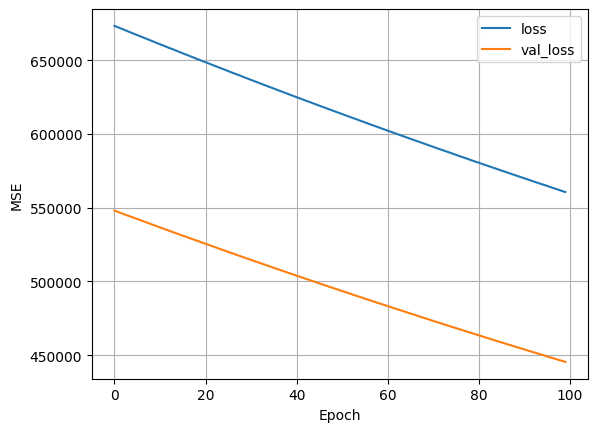

In [57]:
plotLoss(history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F769C3EE80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


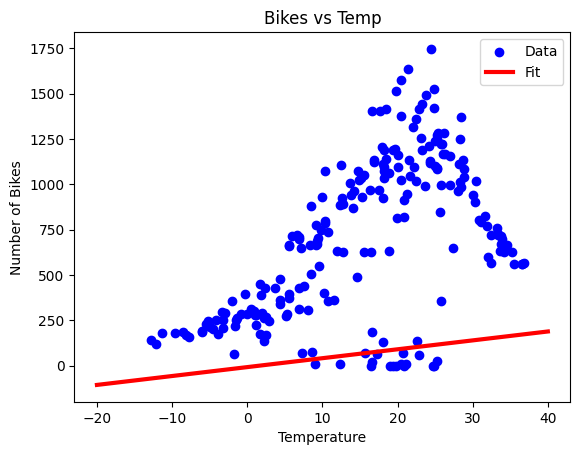

In [58]:
plt.scatter(train_X,train_y,label='Data',color='blue')
x = np.linspace(-20,40,100)
plt.plot(x,nnModel.predict(np.array(x).reshape(-1,1)),label='Fit',color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temperature')
plt.show()

# Using Neural Net with multiple layer

In [59]:
multiNnModel = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])
multiNnModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [60]:
history = multiNnModel.fit(
    train_X,train_y,
    verbose = 1,
    epochs=100,
    validation_data=(valid_X,valid_y)
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 654735.0000 - val_loss: 548791.5625
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 668493.8750 - val_loss: 548791.5625
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 646287.3750 - val_loss: 548791.5625
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 655432.4375 - val_loss: 548791.5625
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 664194.8750 - val_loss: 548791.5625
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 626972.2500 - val_loss: 548791.5625
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 725768.0625 - val_loss: 548791.5625
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 672252.0000 - val_loss: 548791.5625
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 704369.0000 - val_loss: 548791.5625
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 663935.0625 - val_loss: 548791.5625
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 

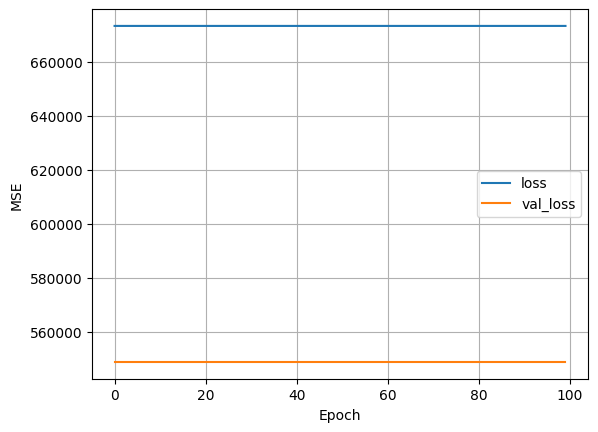

In [61]:
plotLoss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


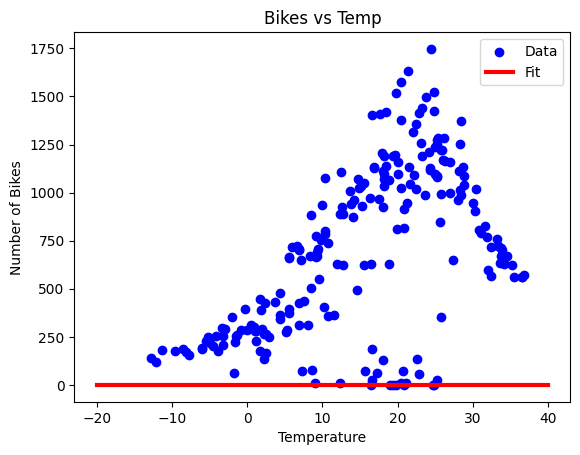

In [62]:
plt.scatter(train_X,train_y,label='Data',color='blue')
x = np.linspace(-20,40,100)
plt.plot(x,multiNnModel.predict(np.array(x).reshape(-1,1)),label='Fit',color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temperature')
plt.show()